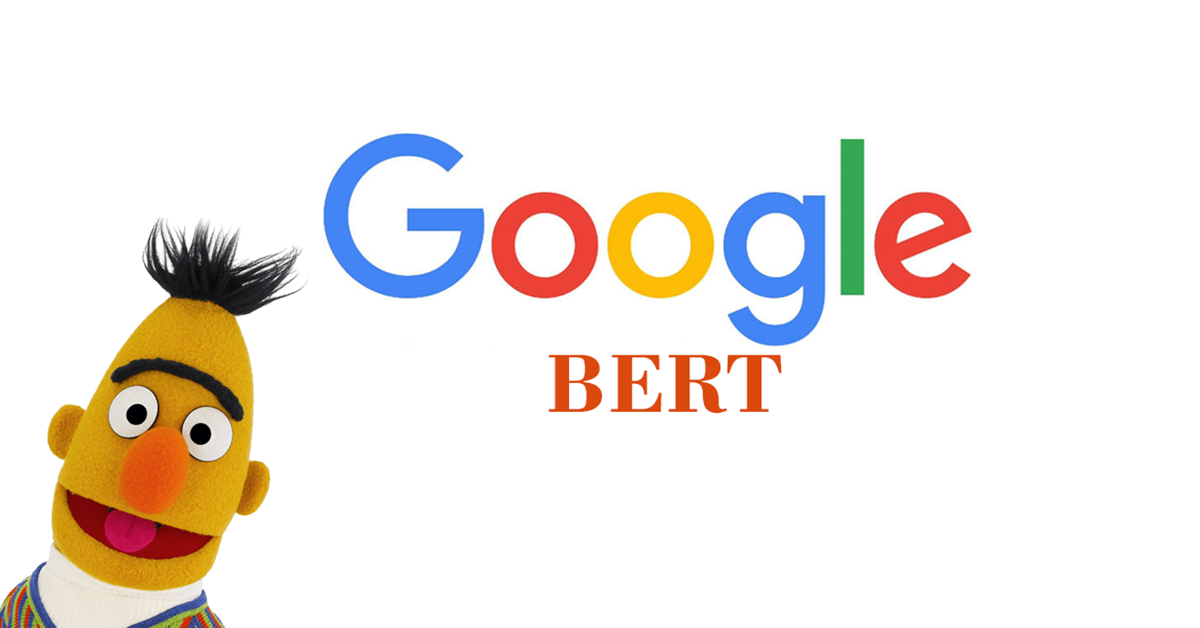

# BERT
### **BERT**, which stands for Bidirectional Encoder Representations from Transformers, is a powerful natural language processing (NLP) model introduced by Google AI researchers in 2018.


### **BERT** is a type of transformer-based model that has had a significant impact on a wide range of NLP tasks, including text classification, named entity recognition, sentiment analysis, and question-answering.

------------------------------------

## **Import Needed Modules**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

## **EDA**

In [ ]:
# Read Data
df = pd.read_csv("/kaggle/input/spam-emails/spam.csv")
df.head()

In [ ]:
# Data information
df.info()

In [ ]:
# Output distribution
df['Category'].value_counts()

#### **15% spam emails, 85% ham emails: This indicates class imbalance**

## **Data Preprocessing**

In [ ]:
# Get all spams labels
spam_df = df[df['Category']=='spam']
spam_df.shape

In [ ]:
# Get all hams labels
ham_df = df[df['Category']=='ham']
ham_df.shape

### **Apply downsample approach**

In [ ]:
# Get random sample from ham data in size of spam data
ham_df_downsampled = ham_df.sample(spam_df.shape[0])
ham_df_downsampled.shape

In [ ]:
# Create balanced data that contains the same size of two categories
balanced_df = pd.concat([ham_df_downsampled, spam_df])
balanced_df.shape

In [ ]:
# New balanced data distribution
balanced_df['Category'].value_counts()

### **Data Encoding**

In [ ]:
# Create a new column that contains encoded values of Category ['ham':0, 'spam':1]
balanced_df['spam']= balanced_df['Category'].apply(lambda x: 1 if x=='spam' else 0)
balanced_df.sample(5)

### **Split it into train and test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['Message'], balanced_df['spam'], stratify=balanced_df['spam'])

### **Now lets import BERT model and get embeding vectors for few sample statements**

In [ ]:
# Preprocessing model
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# BERT model
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# This function apply bert preprocessing on sentences
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

### **Get embeding vectors for few sample words. Compare them using cosine similarity**

In [ ]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

print(cosine_similarity([e[0]],[e[1]]))
print(cosine_similarity([e[2]],[e[3]]))
print(cosine_similarity([e[4]],[e[5]]))

**Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits**

# **Build Model**

**There are two types of models you can build in tensorflow.**
1. **Sequential**
2. **Functional**

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
                                                                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                                                  tf.keras.metrics.Precision(name='precision'),
                                                                  tf.keras.metrics.Recall(name='recall')]
             )

In [ ]:
# Get summary
model.summary()

### **Train the model**

In [ ]:
model.fit(X_train, y_train, epochs=10)

In [ ]:
# Evaluate model
model.evaluate(X_test, y_test)

In [ ]:
# Get prediction
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
# Get label of each predicted value according to a threshold
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

### **Confusion Matrix**

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
cm 

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### **Classification Report**

In [ ]:
print(classification_report(y_test, y_predicted))

# **Test Model**

In [ ]:
emails = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
preds = model.predict(emails)

In [ ]:
labels = ['Not Spam', 'Spam']
for i in range(len(preds)):
    print(f'{emails[i]} ==> {labels[int(np.round(preds[i]))]}')